# MIRO The Explorer

The objective of MIRO The Explorer is to provide an initial look into the parameters describing a 24-hour sine wave:

-   **MESOR** - Mean activity over a 24-hour period,
-   **Amplitude** - Value of peak activity relative to the day’s mean, difference between minimum and maximum activity (2\*amplitude),
-   **Phase shift** - Shift of a sinusoid's peak from the origin on the x-axis (time).

The script will generate a plot showing how these parameters change over time across the experiment's treatment groups, of which there are two in our example.

If you are running MIRO The Explorer via Google Colab, MIRO The Explorer will autodetect and set up the Colab environment in the following cell, and pull example data from the [MIROSLAV toolkit GitHub repository](https://github.com/davorvr/MIROSLAV-analysis).

If you want to run MIRO The Explorer in Google Colab *and* with your own data, you can upload it using the File Browser in the sidebar on the left after running the following cell.

In [7]:
is_colab <- suppressWarnings(system("pip list | grep -F google-colab"))
if (is_colab == 0) {
  system("wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.22_amd64.deb")
  system("apt install ./libssl1.1_1.1.1f-1ubuntu2.22_amd64.deb")
  options(
    HTTPUserAgent =
      sprintf(
        "R/%s R (%s)",
        getRversion(),
        paste(getRversion(), R.version["platform"], R.version["arch"], R.version["os"])
      )
  )
  install.packages("arrow", repos = "https://packagemanager.rstudio.com/all/__linux__/focal/latest")
  install.packages(c("dplyr", "lubridate", "ggplot2", "patchwork"))
  dir.create(file.path(wd, "2_outputs_tidy"), showWarnings = FALSE)
  dir.create(file.path(wd, "3_outputs_R"), showWarnings = FALSE)
  system("wget -O 2_outputs_tidy/mph-pir-tidy-source1minute-resampled5minutes.parquet https://github.com/davorvr/MIROSLAV-analysis/blob/main/2_outputs_tidy/mph-pir-tidy-source1minute-resampled5minutes.parquet")
  system("wget -O 3_outputs_R/mph_sine_data.rds https://github.com/davorvr/MIROSLAV-analysis/raw/main/3_outputs_R/mph_sine_data.rds")
  system("wget -O 3_outputs_R/mph_sine_models.rds https://github.com/davorvr/MIROSLAV-analysis/raw/main/3_outputs_R/mph_sine_models.rds")
}


## Requirements

First, we import the libraries we will require.

In [8]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(patchwork)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




Then, we define useful functions, in this case only one: it will convert a date and time into the integer number of days since the specified start of an experiment.

In [9]:
timestamp_to_nday <- function(dt, start=exp_start) {
  # Turn timestamps into a decimal number of days since start.
  # It's easier to mark events on plots using decimal numbers than timestamps.
  delta_days <- interval(start, dt) %>% as.numeric("days")
  return(delta_days)
}

## Import data

We import the data we will be working on. We need to define:

-   The name of the experiment we want to process
-   The filename of the TidySLAV output file we've originally used with MIROSine
-   The filename of the MIROSine output
-   The experiment's start and end times (as we've specified them to MIROSine).

In [10]:
exp_name <- "mph"
tidydata_filename <- paste0(exp_name, "-pir-tidy-source1minute-resampled5minutes.parquet")
sinedata_filename <- paste0(exp_name, "_sine_data.rds")
exp_start <- as_datetime("2022-05-07 05:46:00")
exp_end <- as_datetime("2022-05-31 17:46:00")

Then, we load TidySLAV data, followed by MIROSine data.

In [11]:
wd <- paste0(getwd(), "/")
data <- arrow::read_parquet(paste0(wd, "2_outputs_tidy/", tidydata_filename))
data$ts_recv <- as_datetime(data$ts_recv, tz="UTC")
data <- data %>% filter(ts_recv >= as_datetime(exp_start, tz="UTC"))
data <- data %>% filter(ts_recv < as_datetime(exp_end, tz="UTC"))
data$hourcount <- difftime(data$ts_recv, min(data$ts_recv), units="hours")
data$hourcount <- as.numeric(data$hourcount)
data$n_day <- data$hourcount %/% 24
day_start_decimal <- 5+46/60
treatments <- unique(data$treatment)

In [12]:
sine_data.file <- paste0(wd, "3_outputs_R/", sinedata_filename)
if (!exists("sine_data"))  {
  if (file.exists(sine_data.file)) {
    sine_data <- readRDS(sine_data.file)
  } else {
    stop("Sine data not found. Either run Section 2 of this script to generate it or check the path in sine_data.file to load from file.")
  }
}
sine_data$date <- as.numeric(sine_data$date)+ymd("1970-01-01")
sine_data$date <- as.factor(sine_data$date)
sine_data$treatment <- as.factor(sine_data$treatment)

## Specifying interesting events

We define variables which tell us when some interesting stuff happened:

-   Point events
-   Administration of intracerebroventricular streptozotocin, used to generate the sporadic Alzheimer's disease model in this example experiment
-   Weighing and bedding change, which ocurred weekly.
-   Time intervals
-   Behavioural testing

### Point events

Sporadic AD model induction with streptozotocin (STZ):

In [13]:
ts_stz <- list(stz_injection_1 = as_datetime("2022-05-11T10:00:00"),
               stz_injection_2 = as_datetime("2022-05-13T10:00:00"))
ts_stz <- lapply(ts_stz, timestamp_to_nday)

Weekly weighing and bedding change (labeled on the x-axis, but we'll draw them as boxes that will cover the whole vertical range, hence the infinite ymin and ymax):

In [14]:
ts_weighing <- data.frame(xmin = c(as_datetime("2022-05-10T08:00:00"), as_datetime("2022-05-18T08:00:00"), as_datetime("2022-05-25T08:00:00")),
                          xmax = c(as_datetime("2022-05-10T12:00:00"), as_datetime("2022-05-18T12:00:00"), as_datetime("2022-05-25T12:00:00")))
ts_weighing$xmin <- interval(exp_start, ts_weighing$xmin) %>% as.numeric("days")
ts_weighing$xmax <- interval(exp_start, ts_weighing$xmax) %>% as.numeric("days")
ts_weighing$ymin <- -Inf
ts_weighing$ymax <- Inf

Behavioural testing:

In [15]:
ts_beh <- data.frame(xmin = c(as_datetime("2022-05-23T14:00:00")),
                     xmax = c(as_datetime("2022-05-26T23:00:00")))
ts_beh$xmin <- interval(exp_start, ts_beh$xmin) %>% as.numeric("days")
ts_beh$xmax <- interval(exp_start, ts_beh$xmax) %>% as.numeric("days")
ts_beh$ymin <- -Inf
ts_beh$ymax <- Inf

## Prepare data to plot

We then calculate the mean, median, and standard deviation of the MESOR, amplitude, and phase for each treatment group and day. We will use these parameters to reconstruct group sine waves and plot estimates for each day.

In [16]:
mean_trim_factor <- 0.05
sine_data.summary <- sine_data %>%
  group_by(n_day, treatment) %>%
  summarise(mesor.mean = mean(mesor, trim=mean_trim_factor), mesor.median = median(mesor), mesor.sd = sd(mesor),
            amplitude.mean = mean(amplitude, trim=mean_trim_factor), amplitude.median = median(amplitude), amplitude.sd = sd(amplitude),
            phase.mean = mean(phase, trim=mean_trim_factor), phase.median = median(phase), phase.sd = sd(phase)) 
sine_data.summary$peak_hour.mean <- 6-(sine_data.summary$phase.mean*(24/(2*pi)))
sine_data.summary$peak_hour.median <- 6-(sine_data.summary$phase.median*(24/(2*pi)))
sine_data.summary$peak_hour.sd <- sd(sine_data.summary$peak_hour.mean)
sine_data.summary <- sine_data.summary %>% 
  mutate(peak_hour = case_when(peak_hour.mean < 0 ~ 24 + peak_hour.mean,
                               .default = peak_hour.mean))
sine_data.summary <- sine_data.summary %>% 
  mutate(peak_hour = case_when(peak_hour.median < 0 ~ 24 + peak_hour.median,
                               .default = peak_hour.median))

sine_data.plot_data <- data.frame(treatment=c(),
                                  n_day=c(),
                                  x_day=c(),
                                  pred_val=c())

for (day in unique(sine_data.summary$n_day)) {
  for (tr in treatments) {
    #    vals <- sine_data.summary %>% filter(n_day == day) %>% filter(treatment == tr)
    #    peak_hour <- 6-(vals$phase_mean*(24/(2*pi)))
    #    if (peak_hour < 0) { peak_hour <- 24+peak_hour }
    df_slice <- sine_data.summary %>% filter(treatment == tr, n_day == day)
    amplitude <- df_slice$amplitude.median
    mesor <- df_slice$mesor.median
    phase <- df_slice$phase.median
    
    hour <- seq(0,23,1)+24*day
    day_seq <- seq(0,0.9,0.1)+day
    #pred_val <- mesor+amplitude*sin(2*pi*((24*day+hour)/24)+phase)
    pred_val <- mesor+amplitude*sin(2*pi*day_seq+phase)
    new_row <- data.frame(treatment=tr,
                          n_day=day,
                          x_day=day_seq,
                          pred_val=pred_val)
    sine_data.plot_data <- rbind(sine_data.plot_data, new_row)
  }
}

`summarise()` has grouped output by 'n_day'. You can override using the
`.groups` argument.


## Exploratory plots

### Parameter view:

#### Group medians + SD over time for MESOR, amplitude, and phase

We plot the group medians and standard deviations of MESOR, amplitude, and phase, for each group, over time. We can also use the mean by changing the `plot_statistic` variable. We can use other parameters as well if we calculate them in the preparation step.

In [17]:
# Controls lines and rectangles marking periods of interest
rect_width <- 1
alpha_weighing <- 0.6
alpha_stz <- 1
stz_linewidth <- 0.3
alpha_behaviour <- 0.4

# Controls how far apart the treatment points and error lines are
dodge_width <- 0.6

# Summary statistic to plot, by default, Section 4. generated means and medians.
# Medians are more robust to outliers. More summary statistics can be generated
# in section 4. as needed.
plot_statistic <- "median" # "mean" or "median" 

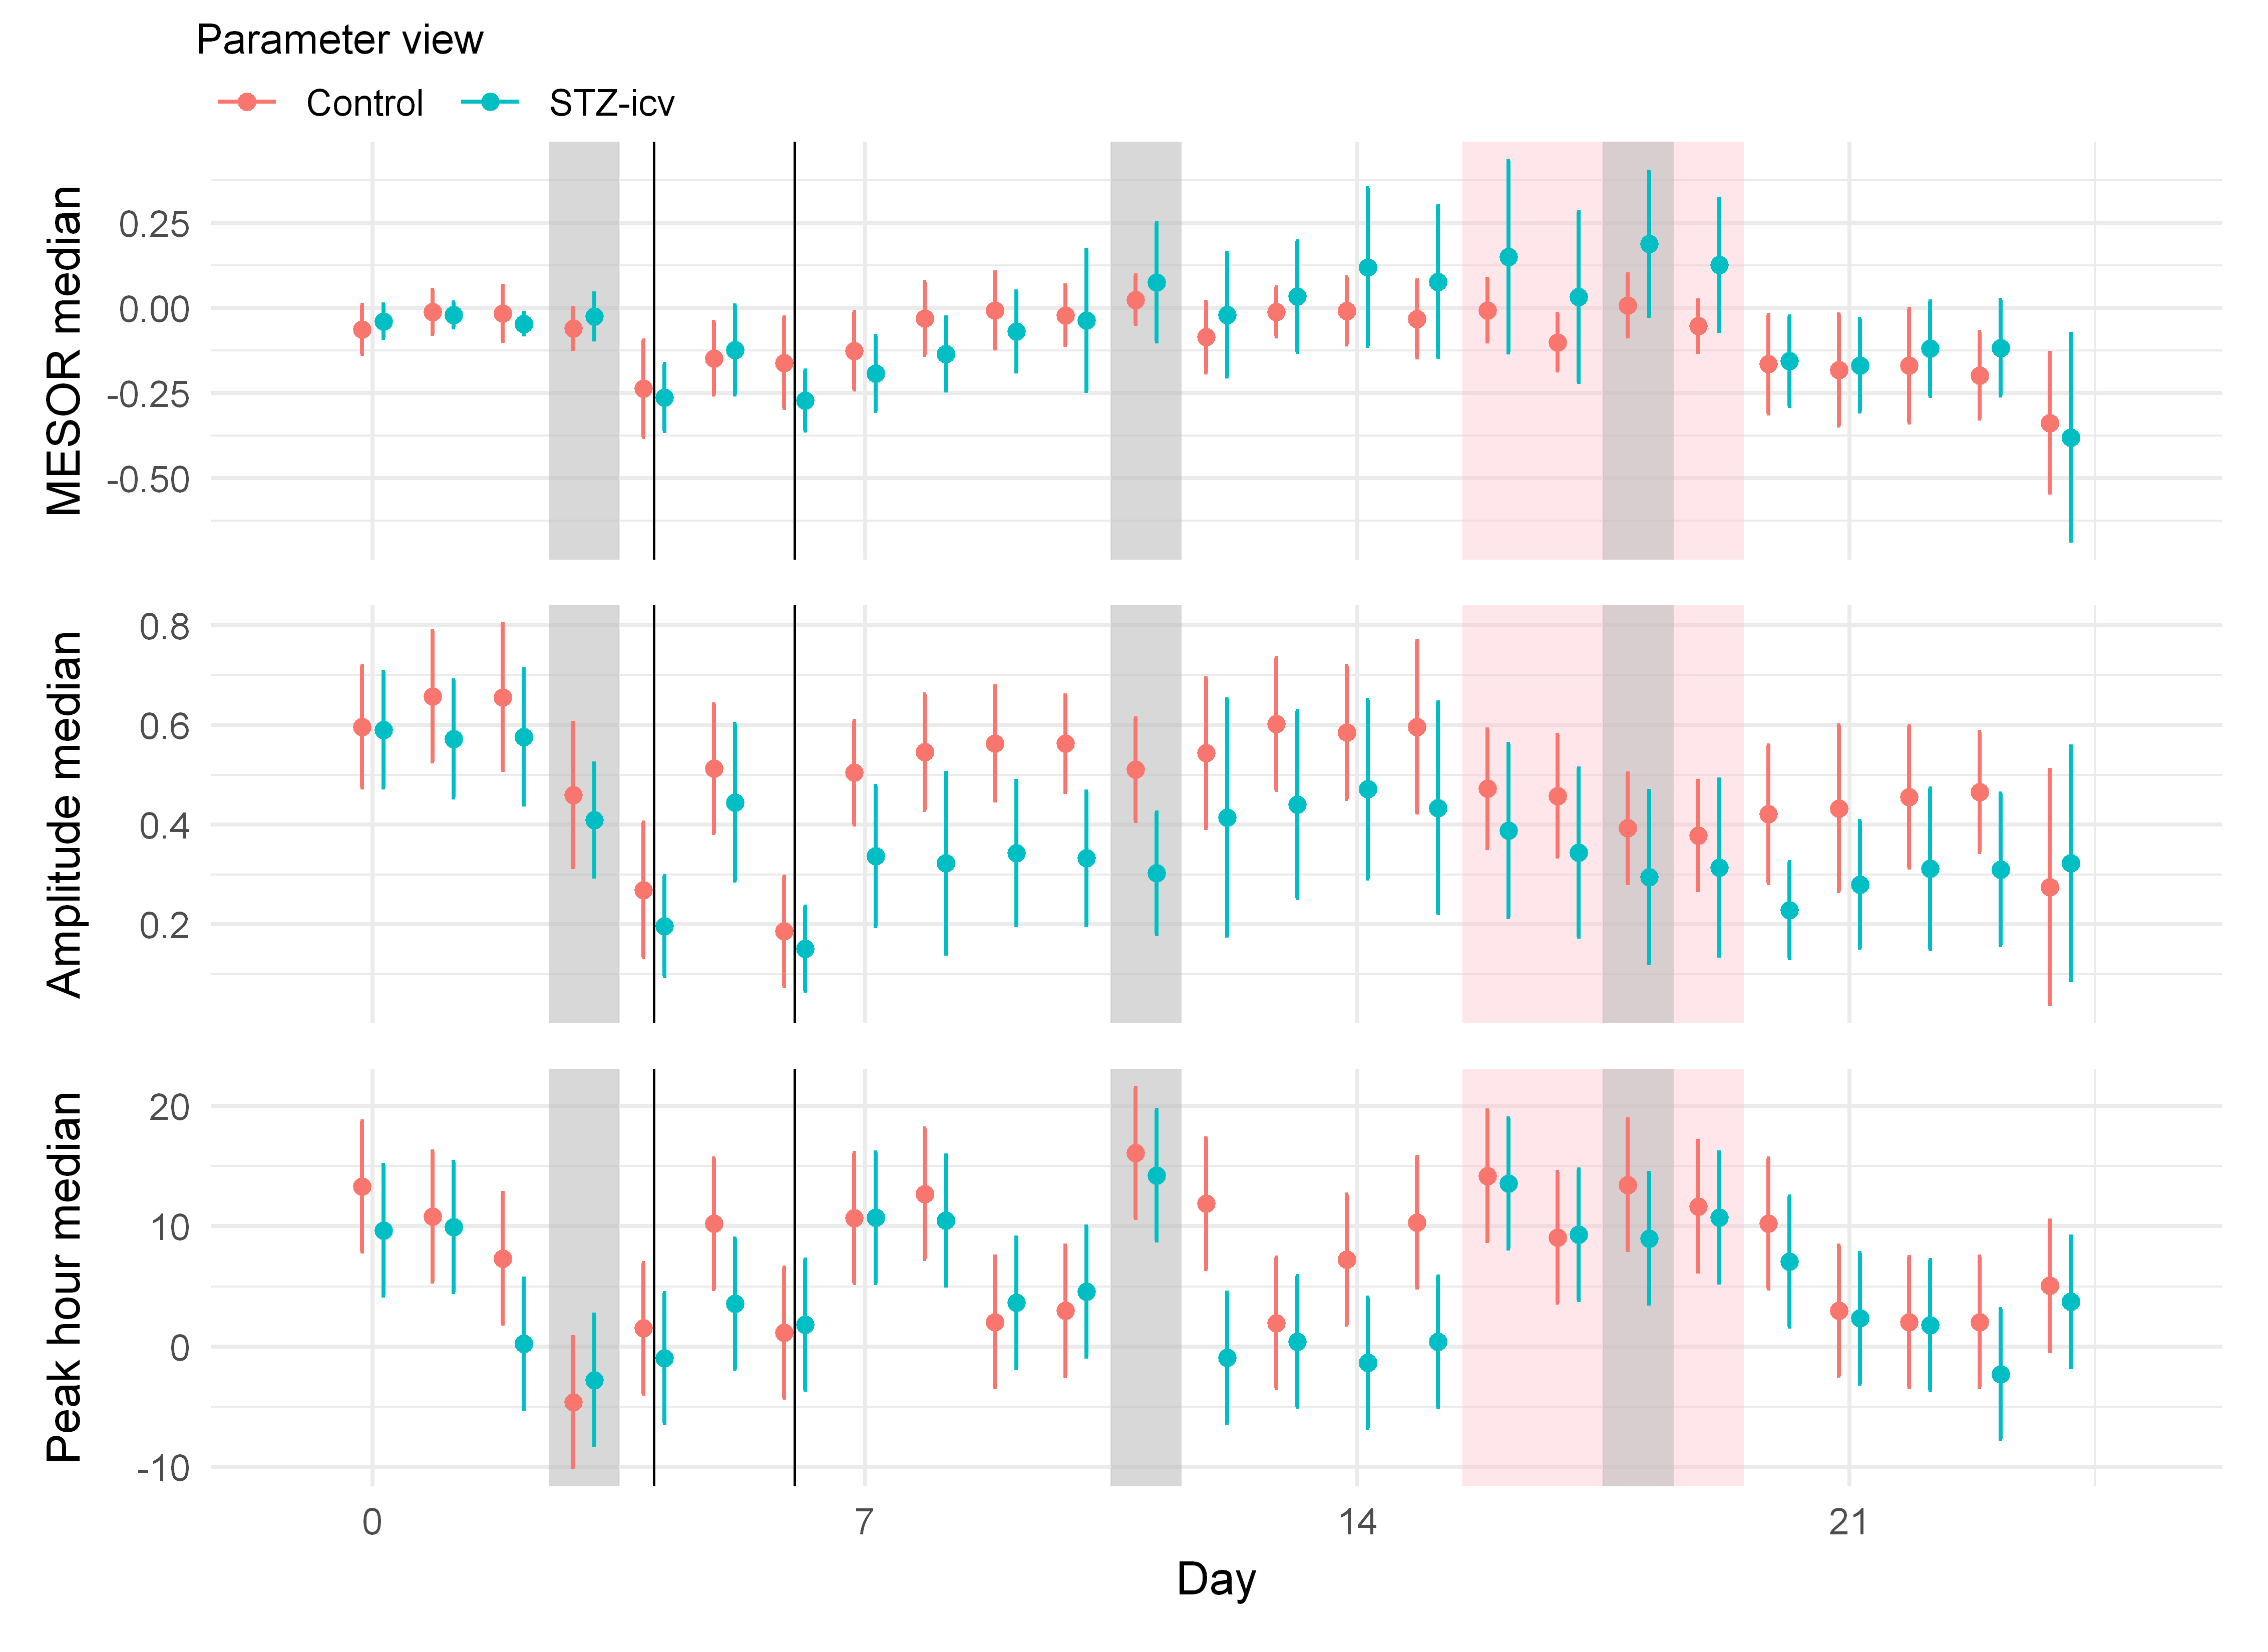

In [18]:
# Mesor - mean of activity levels in one day
p.mesor <- ggplot(sine_data.summary, aes(x=n_day, y=mesor.mean, group=interaction(n_day, treatment), color=treatment))+
  scale_color_discrete(labels=c("Control", "STZ-icv"))+
  scale_x_continuous("Day", breaks = seq(0,70,7), limits=c(min(sine_data.summary$n_day)-1,max(sine_data.summary$n_day)+1))+
  geom_rect(data = ts_beh, inherit.aes=FALSE,
            aes(xmin = floor(xmin)-rect_width/2, xmax = floor(xmax)+rect_width/2, ymin = ymin, ymax = ymax),
            fill = "pink", alpha=alpha_behaviour)+
  geom_rect(data = ts_weighing, inherit.aes=FALSE,
            aes(xmin = floor(xmin)-rect_width/2, xmax = floor(xmax)+rect_width/2, ymin = ymin, ymax = ymax),
            fill = "gray", alpha=alpha_weighing)+
  geom_vline(xintercept = floor(ts_stz$stz_injection_1), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  geom_vline(xintercept = floor(ts_stz$stz_injection_2), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  geom_point(position=position_dodge(width=dodge_width))+
  geom_errorbar(position=position_dodge(width=dodge_width),
                aes(y=mesor.mean,
                    ymin=mesor.mean-mesor.sd,
                    ymax=mesor.mean+mesor.sd),
                width=0.1)+
  theme_minimal()+
  theme(legend.title=element_blank(),
        legend.position="top",
        legend.justification="left")+
  ylab(paste("MESOR", plot_statistic))

# Amplitude - difference between mesor and peak activity
p.amp <- ggplot(sine_data.summary, aes(x=n_day, y=amplitude.mean, group=interaction(n_day, treatment), color=treatment))+
  scale_color_discrete(labels=c("Control", "STZ-icv"))+
  scale_x_continuous("Day", breaks = seq(0,70,7), limits=c(min(sine_data.summary$n_day)-1,max(sine_data.summary$n_day)+1))+
  geom_rect(data = ts_beh, inherit.aes=FALSE,
            aes(xmin = floor(xmin)-rect_width/2, xmax = floor(xmax)+rect_width/2, ymin = ymin, ymax = ymax),
            fill = "pink", alpha=alpha_behaviour)+
  geom_rect(data = ts_weighing, inherit.aes=FALSE,
            aes(xmin = floor(xmin)-rect_width/2, xmax = floor(xmax)+rect_width/2, ymin = ymin, ymax = ymax),
            fill = "gray", alpha=alpha_weighing)+
  geom_vline(xintercept = floor(ts_stz$stz_injection_1), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  geom_vline(xintercept = floor(ts_stz$stz_injection_2), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  geom_point(position=position_dodge(width=dodge_width))+
  geom_errorbar(position=position_dodge(width=dodge_width),
                aes(y=amplitude.mean,
                    ymin=amplitude.mean-amplitude.sd,
                    ymax=amplitude.mean+amplitude.sd),
                width=0.1)+
  theme_minimal()+
  theme(legend.title=element_blank(),
        legend.position="top",
        legend.justification="left")+
  ylab(paste("Amplitude", plot_statistic))

# Phase shift in radians
p.phase <- ggplot(sine_data.summary, aes(x=n_day, y=peak_hour.mean, group=interaction(n_day, treatment), color=treatment))+
  scale_color_discrete(labels=c("Control", "STZ-icv"))+
  scale_x_continuous("Day", breaks = seq(0,70,7), limits=c(min(sine_data.summary$n_day)-1,max(sine_data.summary$n_day)+1))+
  geom_rect(data = ts_beh, inherit.aes=FALSE,
            aes(xmin = floor(xmin)-rect_width/2, xmax = floor(xmax)+rect_width/2, ymin = ymin, ymax = ymax),
            fill = "pink", alpha=alpha_behaviour)+
  geom_rect(data = ts_weighing, inherit.aes=FALSE,
            aes(xmin = floor(xmin)-rect_width/2, xmax = floor(xmax)+rect_width/2, ymin = ymin, ymax = ymax),
            fill = "gray", alpha=alpha_weighing)+
  geom_vline(xintercept = floor(ts_stz$stz_injection_1), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  geom_vline(xintercept = floor(ts_stz$stz_injection_2), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  geom_point(position=position_dodge(width=dodge_width))+
  geom_errorbar(position=position_dodge(width=dodge_width),
                aes(y=peak_hour.mean,
                    ymin=peak_hour.mean-peak_hour.sd,
                    ymax=peak_hour.mean+peak_hour.sd),
                width=0.1)+
  theme_minimal()+
  theme(legend.title=element_blank(),
        legend.position="top",
        legend.justification="left")+
  ylab(paste("Peak hour", plot_statistic))

# Use patchwork to draw plots of the three parameters one below the other
options(repr.plot.width = 7.55, repr.plot.height = 5.5, repr.plot.res = 600)
p.mesor / p.amp / p.phase +
  plot_annotation(title="             Parameter view") +
  plot_layout(guides="collect", axes="collect") &
  theme(legend.title=element_blank(),
        legend.position="top",
        legend.justification="left",
        legend.margin=margin(c(0,0,0,0)),
        legend.spacing.x = unit(0, "mm"), legend.spacing.y = unit(0, "mm"),
        legend.box.margin=margin(-10,0,-10,0),
        plot.title = element_text(size = 10))

ggsave("3_outputs_R/3-2_MIRO-The-Explorer_PV.png", plot=last_plot(), width=7.55, height=5.5, dpi=600)

### Rhythm simulation:

#### Sine-smoothed activity, per group

We reconstruct the sine waves from the group medians of MESOR, amplitude, and phase, and plot them. These are some parameters that can be used to adjust the lines and rectangles describing interesting events.

In [19]:
rect_width <- 1
alpha_weighing <- 0.6
alpha_stz <- 1
stz_linewidth <- 0.3
alpha_behaviour <- 0.4

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"k-d tree limited by memory. ncmax= 250"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"k-d tree limited by memory. ncmax= 250"
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"k-d tree limited by memory. ncmax= 250"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"k-d tree limited by memory. ncmax= 250"


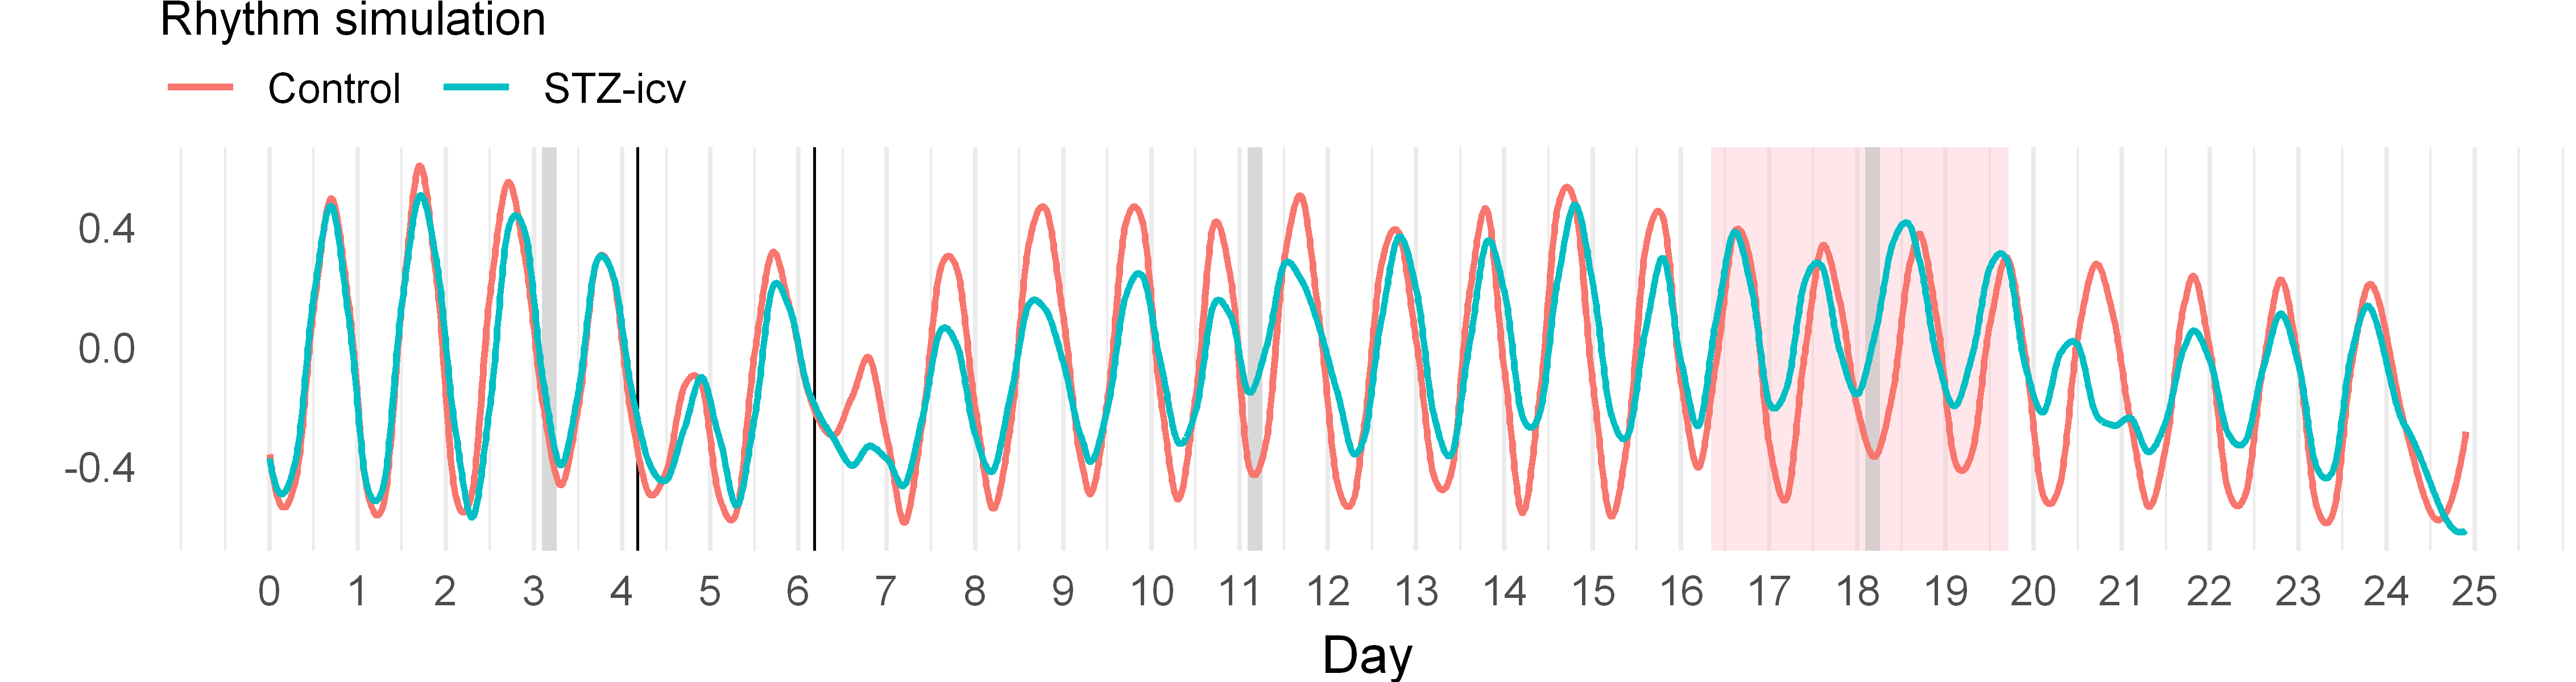

In [20]:
sine_plot <- ggplot(sine_data.plot_data, aes(x=x_day, y=pred_val, color=treatment))+
  scale_x_continuous("Day", breaks = seq(0,25,1))+#, limits=c(min(sine_data.summary$n_day)-1,max(sine_data.summary$n_day)+1))+
  scale_color_discrete(labels=c("Control", "STZ-icv"))+
  geom_rect(data = ts_beh, inherit.aes=FALSE,
            aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
            fill = "pink", alpha=alpha_behaviour)+
  geom_rect(data = ts_weighing, inherit.aes=FALSE,
            aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
            fill = "gray", alpha=alpha_weighing)+
  geom_vline(xintercept = (ts_stz$stz_injection_1), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  geom_vline(xintercept = (ts_stz$stz_injection_2), color = "black", alpha = alpha_stz, linewidth=stz_linewidth)+
  #geom_line(linewidth=0.8)+
  geom_smooth(se = F, span=0.04, n=2400, linewidth=0.7)+
#  geom_point(position=position_dodge(width=0.5))+
#  geom_errorbar(position=position_dodge(width=0.5),
#                aes(y=mesor.mean,
#                    ymin=mesor.mean-mesor.sd,
#                    ymax=mesor.mean+mesor.sd),
#                width=0.1)+
  theme_minimal()+
  theme(plot.title = element_text(size = 10),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        legend.position="top",
        legend.justification="left",
        legend.title=element_blank(),
        legend.margin=margin(c(0,0,0,0)),
        legend.spacing.x = unit(0, "mm"),
        legend.spacing.y = unit(0, "mm"),
        legend.box.margin=margin(-5,0,-7,0),
        plot.margin = unit(c(0,0,0,0), "mm"))+
  ggtitle("Rhythm simulation")+
  ylab("")
options(repr.plot.width = 7.55, repr.plot.height = 2, repr.plot.res = 600)
plot(sine_plot)
ggsave("3_outputs_R/3-2_MIRO-The-Explorer_RS.png", plot=sine_plot, width=7.55, height=2, dpi=600)